## Machine Learning-NLP-Sentiment Analysis of Amazon reviews for JBL Speaker

In this notebook, the reviews from Amazon on JBL Speaker were analyzed. Different machine learning algorithems wre used to perform NLP analysis on the review titles as well as review texts.

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import sqlite3
import warnings
warnings.filterwarnings("ignore")

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
%matplotlib inline

Reading the JBLcleaned sqlite file:

In [5]:
#reading the sqlite file and making a df from the data
con = sqlite3.connect("Amazon.sqlite")
df = pd.read_sql_query("SELECT * from JLBcleaned", con)

In [6]:
df.head()

,rating,date,location,color,review_title,review,comment,feedback,awesome,good,length_of_review
0,1.0,January-29-2019,United States,Gray,Buy a Charge 3,The JBL Charge 4 has one giant flaw that frank...,11,1,0,0,345
1,3.0,December-12-2018,United States,Black,JBL could make the Charger4 better BUT nop the...,Too bad JBL lower the sound quality on the cha...,3,1,0,1,238
2,5.0,October-26-2018,United States,Black,Sounds great and has plenty of colume,I've been using a JBL Flip 2 for the past coup...,1,1,1,1,531
3,5.0,June-3-2019,United States,Gray,In depth review for jbl charge 4,The JBL charge 4 is a great product. I found i...,2,1,1,1,2636
4,4.0,December-5-2018,United States,Red,Awesome Sound! We'll see how long it lasts!,Great build quality.Great sound!Does not autom...,1,1,0,1,614


Here the most frequenctly repeated words in reviews will be retreived.

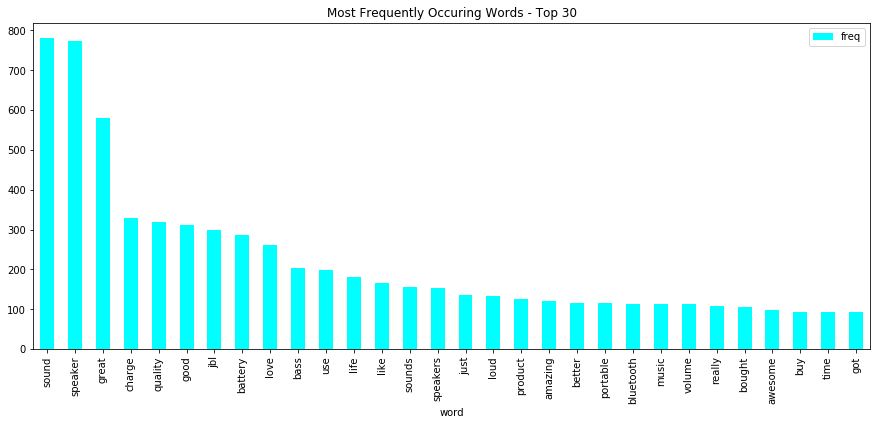

In [7]:
from sklearn.feature_extraction.text import CountVectorizer


cv = CountVectorizer(stop_words = 'english')
words = cv.fit_transform(df.review) #learn a vocabulary
sum_words = words.sum(axis=0)


words_freq = [(word, sum_words[0, idx]) for word, idx in cv.vocabulary_.items()]
words_freq = sorted(words_freq, key = lambda x: x[1], reverse = True)
frequency = pd.DataFrame(words_freq, columns=['word', 'freq'])

frequency.head(30).plot(x='word', y='freq', kind='bar', color='cyan', figsize=(15, 6))
plt.title("Most Frequently Occuring Words - Top 30")
plt.show()

In [127]:
crtfb=df[['color', 'review_title', 'feedback']]

In [128]:
import collections
collections.Counter(crtfb['feedback'])

Counter({1: 27, 0: 1624})

In [132]:
stop_words = set(nltk.corpus.stopwords.words('english'))
sno = nltk.stem.SnowballStemmer('english')

def cleanpunc(sentence):
    cleaned = re.sub(r"[?|!|\'|\"|#]", r"",sentence)
    cleaned =  re.sub(r"[.|,|)|(|\|/]",r"",cleaned)
    return cleaned.lower()

sentences = crtfb['review_title'].values
reviews = []
for sent in sentences:
    cleaned_sent = cleanpunc(sent)
    sent_arr = cleaned_sent.split()
    output_sent = ''
    for word in sent_arr:
        if word not in stop_words:
            stemmed_word = sno.stem(word)
            output_sent = output_sent + ' ' + stemmed_word
    reviews.append(output_sent)

reviews_text = pd.DataFrame({'reviews': reviews})
crtfb = pd.concat([crtfb,reviews_text], axis=1)
crtfb.head()

,color,review_title,feedback,reviews
0,Gray,Buy a Charge 3,1,buy charg 3
1,Black,JBL could make the Charger4 better BUT nop the...,1,jbl could make charger4 better nop dont
2,Black,Sounds great and has plenty of colume,1,sound great plenti colum
3,Gray,In depth review for jbl charge 4,1,depth review jbl charg 4
4,Red,Awesome Sound! We'll see how long it lasts!,1,awesom sound well see long last


In [140]:
crtfb = crtfb[['color', 'feedback', 'reviews']]
from sklearn.utils import resample
data_majority = crtfb[crtfb.feedback == 1]
data_minority = crtfb[crtfb.feedback == 0]
data_minority_upsampled = resample(data_minority,
                                   replace=True,n_samples=2500,random_state=123)
data_upsampled = pd.concat([data_majority, data_minority_upsampled])
final = pd.concat([data_upsampled,
                   pd.get_dummies(data_upsampled['color'],sparse=True)], axis=1)

final.shape

final.drop(['color'], axis=1, inplace=True)
final.head()

,feedback,reviews,Black,Black Camo,Blue,Camouflage,Gray,Green,Pink,Red,Sand,Teal,White,Yellow
0,1,buy charg 3,0,0,0,0,1,0,0,0,0,0,0,0
1,1,jbl could make charger4 better nop dont,1,0,0,0,0,0,0,0,0,0,0,0
2,1,sound great plenti colum,1,0,0,0,0,0,0,0,0,0,0,0
3,1,depth review jbl charg 4,0,0,0,0,1,0,0,0,0,0,0,0
4,1,awesom sound well see long last,0,0,0,0,0,0,0,1,0,0,0,0


In [141]:
count_vect = CountVectorizer(ngram_range=(1,2))
final_counts = count_vect.fit_transform(final['reviews'].values)
print(final_counts.get_shape())
print(final.shape)
final.drop(['reviews'],axis=1,inplace=True)

(2527, 2155)
(2527, 14)


In [142]:
rev_df = pd.DataFrame(final_counts.todense(),columns=count_vect.get_feature_names())

In [143]:
rev_df.shape

(2527, 2155)

In [144]:
final.reset_index(inplace=True, drop=True)
final_df = pd.concat([final,rev_df], axis=1)

In [145]:
final_df.shape

(2527, 2168)

In [146]:
X = final_df.iloc[:,1:].values
y = np.ravel(final_df.iloc[:,0:1].values)

In [149]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=123)

In [150]:
clf = MultinomialNB()
param_disb = { 'alpha': [10**-4,10**-3,10**-2,10**-1,10,1,10**2,10**3,10**4]}
search = GridSearchCV(clf, param_grid=param_disb, cv=5)
search.fit(X_train,y_train)

print(search.best_estimator_)

MultinomialNB(alpha=10, class_prior=None, fit_prior=True)


In [151]:
clf = MultinomialNB(alpha=0.1, class_prior=None, fit_prior=True)
clf. fit(X_train, y_train)
print(confusion_matrix(y_test, clf.predict(X_test)))
print(f"Accuracy Score -> {clf.score(X_test,y_test)}")

[[764  60]
 [  1   9]]
Accuracy Score -> 0.9268585131894485


The bar graph above indicates the most frequently used words in the reviews. This will give us some idea about people's thoughts on the JBL Speaker.

In [84]:
import spacy
import string
import re
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

!python -m spacy download en_core_web_md

stopwords = stopwords.words('english')
punctuations = string.punctuation
nlp = spacy.load('en_core_web_sm')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Kaveh\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


[+] Download and installation successful
You can now load the model via spacy.load('en_core_web_md')


In [85]:
import spacy
import string
import re
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

!python -m spacy download en_core_web_md


stopwords = stopwords.words('english')
punctuations = string.punctuation
nlp = spacy.load('en_core_web_sm')
def cleanup_text(docs, logging=False):
    texts = []
    counter = 1
    table = str.maketrans({key: None for key in string.punctuation})

    for doc in docs:
        if counter % 1000 == 0 and logging:
            print("Processed %d out of %d documents." % (counter, len(docs)))
        counter += 1
        doc = nlp(doc, disable=['parser', 'ner'])
        ###Convert text to lowercase, strip whitespace and remove personal pronouns
        tokens = [tok.lemma_.lower().strip() for tok in doc if tok.lemma_ != '-PRON-']
        ###Remove stopwords
        tokens = [tok.translate(table) for tok in tokens if tok not in stopwords ]
        tokens = ' '.join(tokens)
        #Remove extra whitespace
        tokens = ' '.join(tokens.split())
        texts.append(tokens)
    return pd.Series(texts)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Kaveh\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


[+] Download and installation successful
You can now load the model via spacy.load('en_core_web_md')


Defining two variables (X, y) which are our train and test variables. X that is a train variable, would be a text from 'review_title' and test variable (y) would be the 'feedback'.

In [86]:
X = cleanup_text(df["review_title"],logging=True)
y = df.iloc[:,8].values

Processed 1000 out of 1651 documents.


#### Bag of Words 
The following script uses the bag of words model to convert text documents into corresponding numerical features:


In [87]:
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer(max_features=1500, min_df=5, max_df=0.7)
X_train = vectorizer.fit_transform(X).toarray()

In [88]:
from sklearn.feature_extraction.text import TfidfTransformer
tfidfconverter = TfidfTransformer()
X_train = tfidfconverter.fit_transform(X_train).toarray()

The above script convert values into TFIDF values.

This script divides data into 20% test set and 80% training set.

In [104]:
#training and testing
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(X_train, y, test_size = 0.2, random_state = 0)

print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(1320, 123)
(1320,)
(331, 123)
(331,)


In [105]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix

classifier = RandomForestClassifier()
classifier.fit(x_train, y_train)

y_pred = classifier.predict(x_test)

print("Training Accuracy :", classifier.score(x_train, y_train))
print("Testing Accuracy :", classifier.score(x_test, y_test))

cm = confusion_matrix(y_test, y_pred)
print(cm)

Training Accuracy : 0.990909090909091
Testing Accuracy : 0.9788519637462235
[[322   0]
 [  7   2]]


In [106]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

print( '------------------------------', 'Confusion Matrix:', '\n', confusion_matrix(y_test,y_pred))
print('\n', '------------------------------', 'F1 measure:', '\n', '\n', classification_report(y_test,y_pred))
print('\n',  '------------------------------', 'Accuracy Score:', '\n', accuracy_score(y_test, y_pred))

------------------------------ Confusion Matrix: 
 [[322   0]
 [  7   2]]

 ------------------------------ F1 measure: 
 
              precision    recall  f1-score   support

          0       0.98      1.00      0.99       322
          1       1.00      0.22      0.36         9

avg / total       0.98      0.98      0.97       331


 ------------------------------ Accuracy Score: 
 0.9788519637462235
